## **_Tema : Naive Bayes_**

In [28]:
#Importando las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import model_evaluation_utils as meu

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTETomek
from sklearn.metrics import confusion_matrix, auc, roc_curve
from sklearn.preprocessing import label_binarize
from mlxtend.plotting import plot_decision_regions
from sklearn.naive_bayes import GaussianNB       #Para hacer un modelo Naive-Bayes
from sklearn.svm import SVC                      #Para hacer un modelo de Máquina de Soporte Vectorial

#Just in Case
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Estableciendo mi directorio de trabajo
os.chdir('D:\Social Data Consulting\Python for Data Science\data')

In [4]:
miArchivo='bank-full.csv'
df_bank=pd.read_csv(miArchivo,sep=';')
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### **_Evaluando nulos y balanceos_**

In [5]:
#Evaluando los posibles NAs
df_bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [7]:
#Verificando el porcentaje de las clases en la target(balanceo)
target_freq=pd.value_counts(df_bank.y)*100/len(df_bank)
target_freq

no     88.30152
yes    11.69848
Name: y, dtype: float64

#### **_Codificando las variables tipo object_**

In [9]:
#Instanciamos un objeto de clase defaultdict que tenga como valor un LabelEncoder
d=defaultdict(LabelEncoder)

In [11]:
tipos=df_bank.columns.to_series().groupby(df_bank.dtypes).groups
tipos_object=list(tipos[np.dtype('object')])
print(tipos_object)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


In [13]:
#Haciendo que nuestros datos aprendan y transformen
df_bank2=df_bank.apply(lambda x:d[x.name].fit_transform(x) if x.name in tipos_object else x)
df_bank2.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0


#### **_Balanceo de datos_**

In [14]:
#Estableciendo nuestra matriz de datos X y nuestra variable target
X=df_bank2.iloc[:,0:df_bank2.shape[1]-1].values
y=df_bank2.iloc[:,df_bank2.shape[1]-1].values

In [16]:
#PARTICIONAMOS
xtrain,xtest,ytrain,ytest=train_test_split(X,y, test_size=0.3, random_state=0,stratify=y)

In [18]:
#Tecnica de Balanceo SMOTETomek
st=SMOTETomek(sampling_strategy=0.7,random_state=2020)
xtrain_st,ytrain_st=st.fit_resample(xtrain,ytrain)

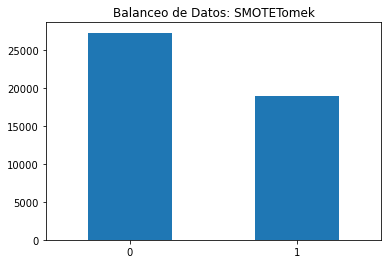

In [21]:
pd.value_counts(ytrain_st).plot(kind='bar',rot=0)
plt.title('Balanceo de Datos: SMOTETomek')
plt.show()

In [23]:
#Extrayendo el nombre de las columnas
columnas=list(df_bank2.columns)
print(columnas)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']


In [24]:
cols_x=columnas[0:df_bank2.shape[1]-1]
cols_y=columnas[df_bank2.shape[1]-1]

In [26]:
data_xs=pd.DataFrame(xtrain_st,columns=cols_x)
data_y=pd.DataFrame(ytrain_st,columns=list(cols_y))
data_train=pd.concat([data_xs,data_y],axis=1)
data_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,34,4,2,2,0,1350,1,0,2,21,8,68,1,-1,0,3,0
1,36,4,2,2,0,1089,1,0,2,30,8,126,1,-1,0,3,0
2,33,1,1,1,0,523,1,0,0,18,8,18,5,360,5,0,0
3,35,7,1,1,0,629,0,1,0,8,5,518,2,-1,0,3,0
4,57,1,1,1,0,25,1,0,0,13,8,378,2,359,1,0,0


In [27]:
data_test_xs=pd.DataFrame(xtest,columns=cols_x)
data_test_y=pd.DataFrame(ytest,columns=list(cols_y))
data_test=pd.concat([data_test_xs,data_test_y],axis=1)
data_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,41,4,0,2,0,647,1,0,2,16,8,270,1,-1,0,3,0
1,20,0,2,1,0,336,0,1,0,5,6,133,1,-1,0,3,0
2,43,9,2,1,0,33,1,0,2,27,8,93,10,-1,0,3,0
3,45,1,2,1,0,3727,0,0,0,6,10,572,1,-1,0,3,0
4,43,7,1,1,0,0,0,0,2,26,8,483,1,-1,0,3,0


### **_Discretizacion_**

In [31]:
#Instanciamos un objeto de clase KBinsDiscretizer
kbd=KBinsDiscretizer(n_bins=3,encode='ordinal',strategy='kmeans')

In [32]:
#Columnas a discretizar
colDiscreta=['age','balance','day','month','duration']

In [33]:
#Aplicando discretización
data_train_discreta=kbd.fit_transform(data_train.loc[:,colDiscreta])
data_test_discreta=kbd.transform(data_test.loc[:,colDiscreta])

In [41]:
data_train_discreta_df=pd.DataFrame(data_train_discreta,columns=colDiscreta)
data_test_discreta_df=pd.DataFrame(data_test_discreta,columns=colDiscreta)

In [42]:
data_train.age=data_train_discreta_df.age
data_train.balance=data_train_discreta_df.balance
data_train.day=data_train_discreta_df.day
data_train.month=data_train_discreta_df.month
data_train.duration=data_train_discreta_df.duration

In [43]:
data_test.age=data_test_discreta_df.age
data_test.balance=data_test_discreta_df.balance
data_test.day=data_test_discreta_df.day
data_test.month=data_test_discreta_df.month
data_test.duration=data_test_discreta_df.duration

In [44]:
#Verificando mi data de entrenamiento discretizada
data_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0.0,4,2,2,0,0.0,1,0,2,1.0,2.0,0.0,1,-1,0,3,0
1,0.0,4,2,2,0,0.0,1,0,2,2.0,2.0,0.0,1,-1,0,3,0
2,0.0,1,1,1,0,0.0,1,0,0,1.0,2.0,0.0,5,360,5,0,0
3,0.0,7,1,1,0,0.0,0,1,0,0.0,1.0,1.0,2,-1,0,3,0
4,2.0,1,1,1,0,0.0,1,0,0,1.0,2.0,0.0,2,359,1,0,0


In [45]:
#Verificando mi data de testeo discretizada
data_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1.0,4,0,2,0,0.0,1,0,2,1.0,2.0,0.0,1,-1,0,3,0
1,0.0,0,2,1,0,0.0,0,1,0,0.0,1.0,0.0,1,-1,0,3,0
2,1.0,9,2,1,0,0.0,1,0,2,2.0,2.0,0.0,10,-1,0,3,0
3,1.0,1,2,1,0,1.0,0,0,0,0.0,2.0,1.0,1,-1,0,3,0
4,1.0,7,1,1,0,0.0,0,0,2,2.0,2.0,1.0,1,-1,0,3,0


### **_Modelando Naive_Bayes_**

In [46]:
#Instanciamos un objeto de clase GaussianNB
clf=GaussianNB()

In [47]:
#Hacemos que nuestro modelo aprenda de los datos balanceados
clf.fit(xtrain_st,ytrain_st)

GaussianNB()

In [48]:
#Calculandremos los Ypredichos
ypredichos=clf.predict(xtrain_st)

In [49]:
#Estableciendo etiquetas
label_names=[0,1]

In [50]:
#Evaluando la performance del modelo para datos de entrenamiento
meu.display_model_performance_metrics(true_labels=ytrain_st,predicted_labels=ypredichos, classes=label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.7608
Precision: 0.8027
Recall: 0.7608
F1 Score: 0.7615

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.91      0.66      0.77     27290
           1       0.65      0.90      0.76     18906

    accuracy                           0.76     46196
   macro avg       0.78      0.78      0.76     46196
weighted avg       0.80      0.76      0.76     46196


Prediction Confusion Matrix:
------------------------------
       0      1
0  18040   9250
1   1802  17104


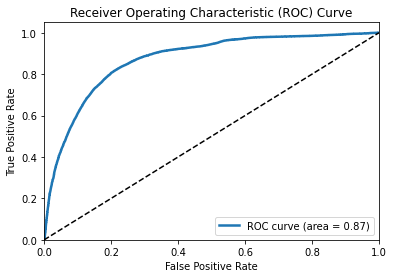

In [51]:
meu.plot_model_roc_curve(clf,xtrain_st,ytrain_st)

In [52]:
#Evaluando la performance del modelo para datos de entrenamiento
ypredicho_test=clf.predict(xtest)
meu.display_model_performance_metrics(true_labels=ytest,predicted_labels=ypredicho_test, classes=label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.6699
Precision: 0.8695
Recall: 0.6699
F1 Score: 0.7286

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     11977
           1       0.23      0.76      0.35      1587

    accuracy                           0.67     13564
   macro avg       0.59      0.71      0.56     13564
weighted avg       0.87      0.67      0.73     13564


Prediction Confusion Matrix:
------------------------------
      0     1
0  7874  4103
1   375  1212


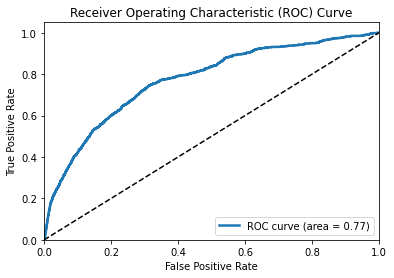

In [53]:
meu.plot_model_roc_curve(clf,xtest,ytest)

## **_Tema : Maquinas de Soporte Vectorial_**

In [85]:
miArchivo='Smarket.csv'
df=pd.read_csv(miArchivo,parse_dates=True,usecols=range(1,10),index_col=0)
df.head()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
Year,,,,,,,,
2001-01-01,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2001-01-01,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2001-01-01,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
2001-01-01,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
2001-01-01,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [86]:
xtrain=df[:'2004'][['Lag1','Lag2']]
xtest=df['2005'][['Lag1','Lag2']]
ytrain=df[:'2004'][['Direction']]
ytest=df['2005'][['Direction']]

In [87]:
#Unificando datos de entrenamiento
data=pd.concat([xtrain,ytrain],axis=1)
data.head()

,Lag1,Lag2,Direction
Year,,,
2001-01-01,0.381,-0.192,Up
2001-01-01,0.959,0.381,Up
2001-01-01,1.032,0.959,Down
2001-01-01,-0.623,1.032,Up
2001-01-01,0.614,-0.623,Up


In [101]:
data_test=pd.concat([xtest,ytest],axis=1)
data_test.head()

,Lag1,Lag2,Direction
Year,,,
2005-01-01,-0.134,0.008,Down
2005-01-01,-0.812,-0.134,Down
2005-01-01,-1.167,-0.812,Down
2005-01-01,-0.363,-1.167,Up
2005-01-01,0.351,-0.363,Down


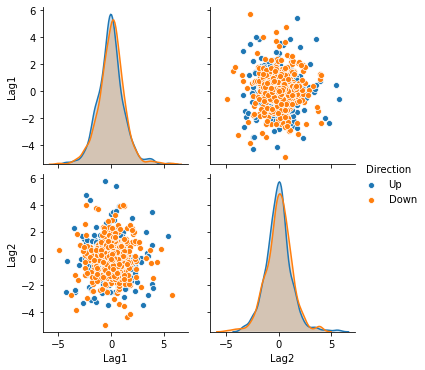

In [89]:
#Visualizando el ploteo de los datos
sns.pairplot(data,hue='Direction')

### Construyendo el modelo

In [90]:
#Instanciando un objeto de calse SVC
clf=SVC(kernel='rbf',gamma=0.1,random_state=0)

In [102]:
#Extrayendo los arrays para el aprendizaje
xtrain_array=xtrain.iloc[:,[0,1]].values
ytrain_array=data.iloc[:,2].values

In [103]:
#Recategorizando la target
ytrain_array=np.where(ytrain_array=='Down',0,1)

In [104]:
xtest_array=xtest.iloc[:,[0,1]].values
ytest_array=data_test.iloc[:,2].values

In [105]:
#Recategorizando la target
ytest_array=np.where(ytest_array=='Down',0,1)

In [95]:
#Haciendo que mi modelo aprenda de los datos
svc.fit(xtrain_array,ytrain_array)

SVC(gamma=0.1, random_state=0)

In [96]:
#Haciendo el calculo de los valores predichos
ypredicho_train=svc.predict(xtrain_array)
ypredicho_test=svc.predict(xtest_array)

In [97]:
#Generando labels
label_name=[0,1]

In [98]:
#Evaluando la performance del modelo (Data de Entrenamiento)
meu.display_model_performance_metrics(true_labels=ytrain_array,predicted_labels=ypredicho_train,classes=label_name)

Model Performance metrics:
------------------------------
Accuracy: 0.5361
Precision: 0.5473
Recall: 0.5361
F1 Score: 0.4928

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.57      0.24      0.34       491
           1       0.53      0.82      0.64       507

    accuracy                           0.54       998
   macro avg       0.55      0.53      0.49       998
weighted avg       0.55      0.54      0.49       998


Prediction Confusion Matrix:
------------------------------
     0    1
0  118  373
1   90  417


In [107]:
#meu.plot_model_roc_curve(svc,xtrain_array,ytrain_array,class_names=label_name)